In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import napari
import colorcet as cc
import pandas as pd

import dnt

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"D:\Tracking\DrosophilaNucleusTracking\figures\output")

include = [1, 3, 4, 6, 7, 8]
earliest_frames = [25, 48, 43, 63, 80, 30]

dnt.set_plot_style()
spots_dfs, metadatas, stems = dnt.load_spots_data(spots_directory, include)

df = spots_dfs[0]
cycles = [10, 11, 12, 13, 14]

print(df.columns)

['lightsheet_20241104_spots', 'lightsheet_20250131_spots', 'lightsheet_20250206_spots', 'lightsheet_20250414_spots', 'lightsheet_20250625_spots', 'lightsheet_20250627_spots', 'lightsheet_20250702_spots', 'lightsheet_20250704_spots', 'lightsheet_20250705_spots', 'lightsheet_trk_20250318_spots', 'lightsheet_trk_20250319a_spots', 'lightsheet_trk_20250319b_spots', 'lightsheet_trk_20250321_spots', 'lightsheet_trk_20250325_spots']


reading spots dfs: 14it [00:05,  2.60it/s]

Index(['time_since_nc11', 'z', 'y', 'x', 'AP', 'theta', 'area', 'radius',
       'intensity_mean', 'cycle', 'display_z', 'display_y', 'display_x',
       'px_z', 'px_y', 'px_x', 'px_area', 'uv_v', 'uv_u', 'uv_z',
       'uv_distance_from_edge', 'distance_from_surface', 'uv_area',
       'area_distortion', 'mesh_name', 'interpolated', 'track_id',
       'tracklet_id', 'parent_id', 'n_children', 'n_parents', 'AP_raw',
       'AP_um', 'AP_um_centered', 'um_from_anterior', 'um_from_posterior',
       'distance_to_pole', 'time', 'trk', 'problematic', 'frame',
       'trackmate_id', 'source', 'pseudotime', 'distance', 'cycle_pseudotime',
       'dx', 'dy', 'dz', 'dAP', 'dtheta', 'dtot', 'dAP_abs'],
      dtype='object')


In [59]:
import dnt
import pandas as pd
from collections import defaultdict

all_densities = defaultdict(list)
for k in range(6):
    df = spots_dfs[k]
    df = df[df["frame"] >= earliest_frames[k]].copy()

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    points = df[df["frame"] == min_mvmt_frames[-1]][["x", "y", "z"]].values
    mesh = dnt.mesh_from_points(points)

    ap_vals = np.linspace(0.05, 0.95, 6)
    y_max = points[:, 1].max()
    y_min = points[:, 1].min()
    y_vals = y_min + ap_vals * (y_max - y_min)

    bins = [-1] + list(ap_vals) + [2]

    df["AP_bin"] = pd.cut(df["AP"], bins=bins, labels=np.arange(len(bins)-1))
    df["AP_bin"] = df["AP_bin"].astype(int)

    surface_areas = dnt.calculate_surface_area_along_axis(mesh, y_vals)
    total_surface_area = surface_areas.sum()
    surface_areas = surface_areas[1:-1]

    rel_densities = []

    for frame, cycle in zip(min_mvmt_frames, cycles):
        df_subset = df[df["frame"] == frame]
        df_subset = df_subset[df_subset["AP_bin"].isin([1, 2, 3, 4, 5])]

        actual_density = df_subset.groupby("AP_bin").size() / surface_areas
        rel_density = actual_density / (len(df_subset) / total_surface_area)

        rel_densities.append(rel_density.values)

        for bin_idx, (actual, rel) in enumerate(zip(actual_density.values, rel_density.values)):
            all_densities["cycle"].append(cycle)
            all_densities["embryo"].append(k)
            all_densities["AP_bin"].append(bin_idx + 1)
            all_densities["actual_density"].append(actual)
            all_densities["rel_density"].append(rel)
            all_densities["surface_area"].append(surface_areas[bin_idx])

    spots_dfs[k] = df


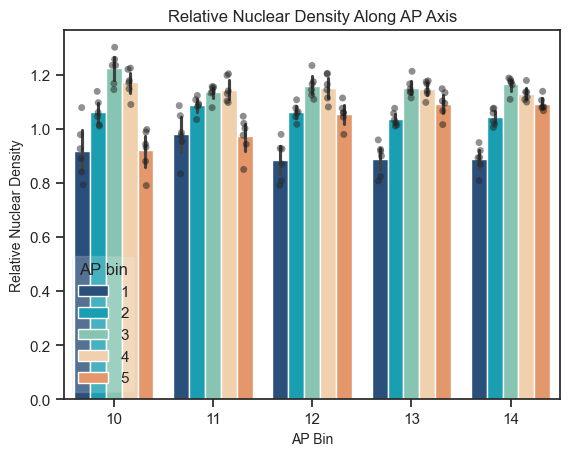

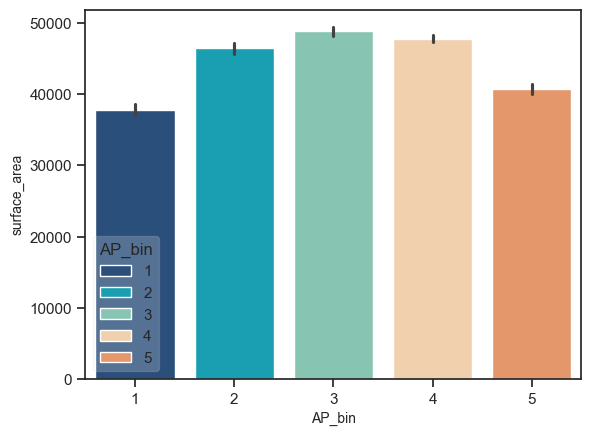

In [60]:
density_df = pd.DataFrame(all_densities)
sns.barplot(data=density_df, x="cycle", y="rel_density", hue="AP_bin", palette=list(dnt.palettes.nc.values()))
sns.stripplot(data=density_df, x="cycle", y="rel_density", hue="AP_bin", dodge=True, palette='dark:k', alpha=0.5, legend=False)
plt.xlabel("AP Bin")
plt.ylabel("Relative Nuclear Density")
plt.title("Relative Nuclear Density Along AP Axis")
plt.legend(title="AP bin")
# plt.savefig(save_path / "nc_relative_density_ap.png", dpi=300)
plt.show()

density_df = pd.DataFrame(all_densities)
sns.barplot(data=density_df, x="AP_bin", y="surface_area", hue="AP_bin", palette=list(dnt.palettes.nc.values()))

plt.show()

prev_bin   1.0    2.0    3.0    4.0   5.0   6.0
AP_bin                                         
0          1.0    0.0    0.0    0.0   0.0   0.0
1         73.0    8.0    0.0    0.0   0.0   0.0
2          0.0  114.0   14.0    0.0   0.0   0.0
3          0.0    0.0  146.0    4.0   0.0   0.0
4          0.0    0.0    6.0  131.0   1.0   0.0
5          0.0    0.0    0.0   11.0  80.0   0.0
6          0.0    0.0    0.0    0.0   4.0  14.0
prev_bin   0.0    1.0    2.0    3.0    4.0    5.0   6.0
AP_bin                                                 
0         16.0    3.0    0.0    0.0    0.0    0.0   0.0
1          2.0  187.0    0.0    0.0    0.0    0.0   0.0
2          0.0   31.0  246.0    0.0    0.0    0.0   0.0
3          0.0    0.0   40.0  253.0    0.0    0.0   0.0
4          0.0    0.0    0.0   60.0  230.0    0.0   0.0
5          0.0    0.0    0.0    0.0   60.0  146.0   0.0
6          0.0    0.0    0.0    0.0    0.0   29.0  18.0
prev_bin   0.0    1.0    2.0    3.0    4.0    5.0   6.0
AP_bin  

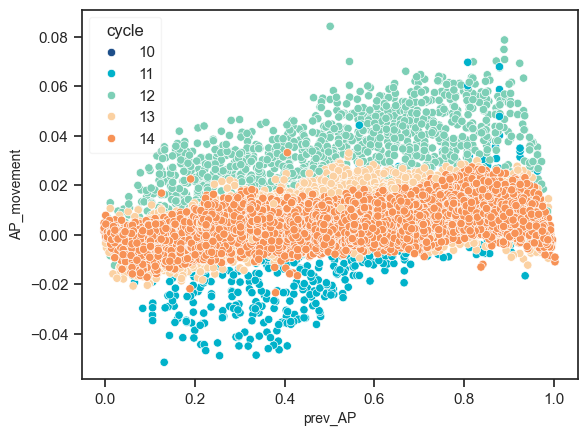

prev_bin       0.0    1.0    2.0     3.0    4.0    5.0    6.0
cycle AP_bin                                                 
11    0        NaN    1.0    NaN     NaN    NaN    NaN    NaN
      1        NaN   73.0    8.0     NaN    NaN    NaN    NaN
      2        NaN    NaN  114.0    14.0    NaN    NaN    NaN
      3        NaN    NaN    NaN   146.0    4.0    NaN    NaN
      4        NaN    NaN    NaN     6.0  131.0    1.0    NaN
      5        NaN    NaN    NaN     NaN   11.0   80.0    NaN
      6        NaN    NaN    NaN     NaN    NaN    4.0   14.0
12    0       16.0    3.0    NaN     NaN    NaN    NaN    NaN
      1        2.0  187.0    NaN     NaN    NaN    NaN    NaN
      2        NaN   31.0  246.0     NaN    NaN    NaN    NaN
      3        NaN    NaN   40.0   253.0    NaN    NaN    NaN
      4        NaN    NaN    NaN    60.0  230.0    NaN    NaN
      5        NaN    NaN    NaN     NaN   60.0  146.0    NaN
      6        NaN    NaN    NaN     NaN    NaN   29.0   18.0
13    0 

In [63]:
k = 0
df = spots_dfs[k].copy()
df = df[df["frame"] >= earliest_frames[k]]

timepoint_df = dnt.generate_timepoint_df(df)

timepoint_df["prev_AP"] = timepoint_df["prev_id"].map(timepoint_df["AP"])
timepoint_df["AP_movement"] = timepoint_df["AP"] - timepoint_df["prev_AP"]

timepoint_df["prev_bin"] = timepoint_df["prev_id"].map(timepoint_df["AP_bin"])
# timepoint_df["AP_bin_movement"] = timepoint_df["AP_bin"] - timepoint_df["prev_bin"]

for cycle in [11, 12, 13, 14]:
    subset = timepoint_df[timepoint_df["cycle"] == cycle]
    print(subset.groupby(["AP_bin", "prev_bin"])["frame"].count().unstack().fillna(0))

sns.scatterplot(data=timepoint_df, x="prev_AP", y="AP_movement", hue="cycle", palette=dnt.palettes.nc)
plt.show()

print(timepoint_df.groupby(["cycle", "AP_bin", "prev_bin"])["frame"].count().unstack().fillna(0))

print(len(timepoint_df))